In [65]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from numba import njit
from KDEpy import FFTKDE
from scipy.interpolate import CubicSpline

# Burgers' equation

Burgers' equation, also called the Bateman-Burgers equation, is a one of the simplest and most common examples of a non-linear PDE:

$$ \frac{\partial u}{\partial t} = -u \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2}. $$

We see that it is (sort of) an advection-diffusion equation for the property $u$, where $u$ also appears as a factor in the advection velocity.

### The advection-diffusion equation 

The regular advection-diffusion equation for a concentration $C$, where the advection velocity, $v$, is a function of space, and the diffusivity, $K$, is a constant, is:

$$ \frac{\partial C}{\partial t} = -\frac{\partial }{\partial x}(v C) + K \frac{\partial^2 C}{\partial x^2}. $$

If we rewrite this a little by using the product rule for differentiation,  we get

$$ \frac{\partial C}{\partial t} = -v\frac{\partial C}{\partial x} -C\frac{\partial v}{\partial x} + K \frac{\partial^2 C}{\partial x^2}, $$

and if we let $v=C/2$, we end up with Burgers' equation:

\begin{align} \frac{\partial C}{\partial t} = &- \left( \frac{C}{2}\frac{\partial C}{\partial x} + C \frac{1}{2}\frac{\partial C}{\partial x}\right) + K \frac{\partial^2 C}{\partial x^2},\\
= &- C\frac{\partial C}{\partial x} + K \frac{\partial^2 C}{\partial x^2}.
\end{align}

So we conclude that Burgers' equation is an advection-diffusion equation where the advection velocity is equal to the concentration divided by 2.


### The Fokker-Planck equation and an SDE

We next compare this to the Fokker-Planck equation:

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} ( ap ) + \frac{1}{2} \frac{\partial^2}{\partial x^2} ( b^2 p ), $$

and if we let $a = p/2$ and $b=\sqrt{2 K}$ we end up with Burgers' equation.

Thus we find that an SDE consistent with Burgers' equation is:

$$ \mathrm{d} X_t = \frac{1}{2} p(X_t, t) \, \mathrm{d} t + \sqrt{2 K}\, \mathrm{d} W_t. $$

This type of SDE, where one or both of the drift and diffusion terms depend on the probability distribution of solutions to the same SDE, is called a distribution-dependent SDE (DDSDE). The literature on this topic appears to be both somewhat limited and quite technical, and I haven't been able to find much on numerical methods. What we will go through here is just a couple of pragmatic approaches that seem to more or less work, when compared to the solution of the PDE directly.


### Some notes on terminology

If $\nu > 0$, it is called the _viscous Burgers' equation_, and if $\nu = 0$ it is called the _inviscid Burgers' equation_. We also talk about the _generalised Burgers' equation_, where the advection velocity, $v(u)$ is some general function of $u$:

$$ \frac{\partial u}{\partial t} = -v(u) \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2}. $$

## Numerical solution of the Burgers' PDE

We will solve the viscous Burgers' equation, using an upwind scheme (one-sided finite difference) for the first derivative in the advection term, and a second-order central finite difference for the second derivative in the diffusion term. We discretise space such that $x_n = x_0 + n \Delta x$, and time such that $t_i = t_0 + i \Delta t$.

First, we rewrite the advection term in Burgers' equation to the so-called conservative form by introducing the function $F(u) = u^2 / 2$:

$$ -u \frac{\partial u}{\partial x} = -  \frac{\partial}{\partial x} \frac{u^2}{2} =  -  \frac{\partial}{\partial x} F(u). $$


Assuming that $u$ is positive, and using the notation where $u_n^i = u(x_n, t_i)$, we numerically approximate Burgers' equation by

$$ u_n^{i+1} = u_n^i + \Delta t \left[ -\frac{F(u_n^i) - F(u_{n-1}^i)}{\Delta x} + \nu \frac{u_{n+1}^i - 2u_n^i + u_{n-1}^i}{\Delta x^2} \right]. $$

Note that there are other, better ways of solving Burgers' equation numerically, but we choose this one here as it is very simple to implement and accurate enough as long as we use small enough $\Delta x$ and $\Delta t$.

In [230]:
def upwind(u, dx):
    # Note, we assume that u >= 0 everywhere
    return (u[1:-1] - u[:-2]) / (dx)

def central_2nd(u, dx):
    return (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2

def burgers(u0, x, Tmax, dt, nu=0.0):
    Nt = round(Tmax/dt) + 1
    Nx = len(x)
    dx = x[1] - x[0]
    u = np.zeros((Nt, Nx))
    u[0,:] = u0.copy()
    
    for i in trange(1, Nt):
        u[i,1:-1] = u[i-1,1:-1] -dt*upwind(u[i-1,:]**2 / 2, dx) + nu*dt*central_2nd(u[i-1,:], dx)
    t = np.linspace(0, Tmax, Nt)
    return u, t

K*dt/dx**2 = 0.034999999999999996
CFL = 0.055851919256200575


  0%|          | 0/28571 [00:00<?, ?it/s]

0.9999685957048591
0.9999492759525213
0.9999367598705704


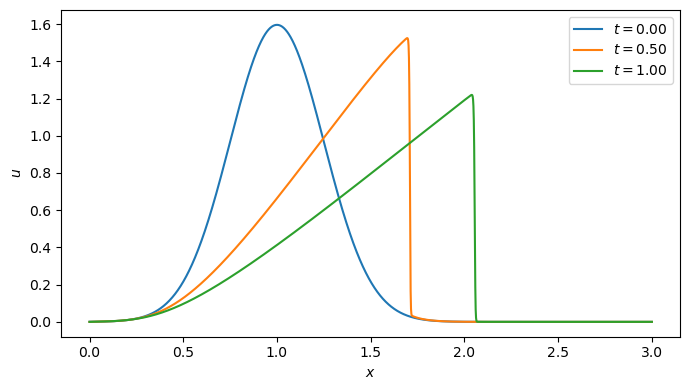

In [236]:
### PDE solution ###
nx = 3001  # number of spatial grid points
x, dx = np.linspace(0, 3, nx, retstep=True)
dt = 0.000035
u0 = gaussian(x, 1, 0.25)
nu = 0.001

# Check stability condition for this method
print(f'K*dt/dx**2 = {nu*dt/dx**2}')
print(f'CFL = {np.amax(u0)*dt/dx}')

u, times = burgers(u0, x, Tmax, dt, nu=nu)

fig = plt.figure(figsize=(7,4))

for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    plt.plot(x, u[it,:], label=f'$t={it*dt:.2f}$')
    print(np.sum(u[it,:]*dx))

plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.tight_layout()

## Solving the corresponding SDE

The equation we want to solve,

$$ \mathrm{d} X_t = \frac{1}{2} p(X_t, t) \, \mathrm{d} t + \sqrt{2 K}\, \mathrm{d} W_t, $$

contains the probability density of solutions, $p(X_t, t)$. There are a few different approaches we might choose to handle this:
* If $p(X_t, t)$ is known analytically, then we can just treat the equation as any other SDE where $a(X_t, t)$ is given by an analytical expression.
* We could find $p(X_t, t)$ by solving the PDE numerically.
* Or, we could solve for a large ensemble of solutions, and estimate $p(X_t, t)$ from the set of solutions.

We will look at the last option, and consider two different variants:
* Solve for a large number of $X_t$, and approximate $p(X_t, t)$ by KDE (kernel density estimation)
* Solve for a large number of $X_t$, and approximate $p(X_t, t)$ by histogram

In [242]:
def burgers_SDE_kernel(x0, tmax, dt, nu=0.0, bw='silverman'):
    Nt = int(tmax/dt) + 1
    Np = len(x0)
    X = np.zeros((Nt, Np))
    X[0,:] = x0.copy()
    tmp = np.linspace(-2, 4, 1000)
    for i in trange(1, Nt):
        # Fit to data, and evaluate
        estimator = FFTKDE(kernel='gaussian', bw=bw)
        u = CubicSpline(tmp, estimator.fit(X[i-1,:]).evaluate(tmp))
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=Np)
        X[i,:] = X[i-1,:] + 0.5*u(X[i-1,:])*dt + np.sqrt(2*nu)*dW
    t = np.linspace(0, tmax, Nt)
    return X, t

  0%|          | 0/100 [00:00<?, ?it/s]

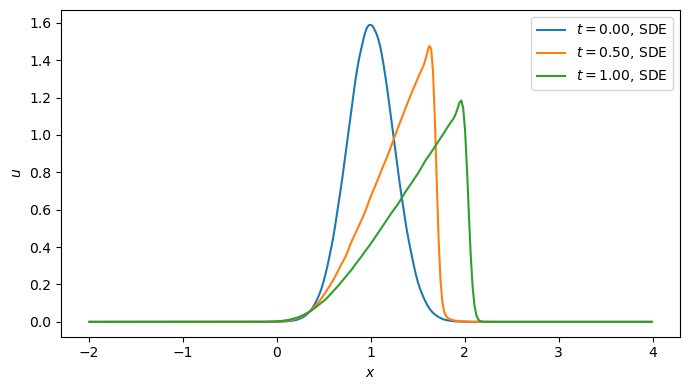

In [243]:
Np = 1000000
X0 = np.random.normal(loc=1, scale=0.25, size=Np)
Tmax = 1
dt = 0.01

X, times = burgers_SDE_kernel(X0, Tmax, dt, nu=0.01)

bins = np.linspace(-2, 4, 300)
mids = bins[:-1] + (bins[1]-bins[0])/2

fig = plt.figure(figsize=(7,4))

for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    estimator = FFTKDE(kernel='gaussian', bw=bw)
    plt.plot(mids, estimator.fit(X[it,:]).evaluate(mids), label=f'$t={it*dt:.2f}$, SDE')

plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.tight_layout()

K*dt/dx**2 = 0.000
CFL = 0.056


  0%|          | 0/28571 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

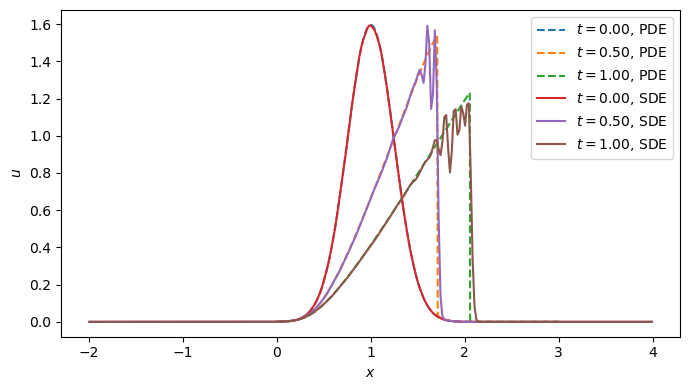

In [244]:
# Common parameters
nu = 0.0
Tmax = 1.0


### PDE solution ###
nx = 3001  # number of spatial grid points
x, dx = np.linspace(0, 3, nx, retstep=True)
u0 = gaussian(x, 1, 0.25)
dt = 0.000035

# Check stability condition for this method
print(f'K*dt/dx**2 = {nu*dt/dx**2:.3f}')
print(f'CFL = {np.amax(u0)*dt/dx:.3f}')

u, times = burgers(u0, x, Tmax, dt, nu=nu)


fig = plt.figure(figsize=(7,4))
for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    plt.plot(x, u[it,:], '--', label=f'$t={it*dt:.2f}$, PDE')


### SDE solution ###
Np = 1000000
X0 = np.random.normal(loc=1, scale=0.25, size=Np)
dt = 0.01
bw = 'silverman'

X, times = burgers_SDE_kernel(X0, Tmax, dt, nu=nu, bw=bw)

bins = np.linspace(-2, 4, 300)
mids = bins[:-1] + (bins[1]-bins[0])/2


for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    estimator = FFTKDE(kernel='gaussian', bw=bw)
    plt.plot(mids, estimator.fit(X[it,:]).evaluate(mids), label=f'$t={it*dt:.2f}$, SDE')




plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.tight_layout()

In [255]:
def burgers_SDE_histogram(x0, tmax, dt, nu=0.0, bin_width=0.01):
    Nt = int(tmax/dt) + 1
    Np = len(x0)
    X = np.zeros((Nt, Np))
    X[0,:] = x0.copy()
    tmp = np.linspace(-2, 4, 1000)
    for i in trange(1, Nt):
        # Create histogram bins that cover all solutions
        L = np.amax(X[i-1,:]) - np.amin(X[i-1,:])
        Nbins = int(L/bin_width) + 3
        bins = np.linspace(np.amin(X[i-1,:]) - 1.5*bin_width, np.amax(X[i-1,:]) + 1.5*bin_width, Nbins)
        h, _ = np.histogram(X[i-1,:], bins=bins, density=True)
        u = h[np.searchsorted(bins, X[i-1,:])]
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=Np)
        X[i,:] = X[i-1,:] + 0.5*u*dt + np.sqrt(2*nu)*dW
    t = np.linspace(0, tmax, Nt)
    return X, t

K*dt/dx**2 = 0.100
CFL = 0.016


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

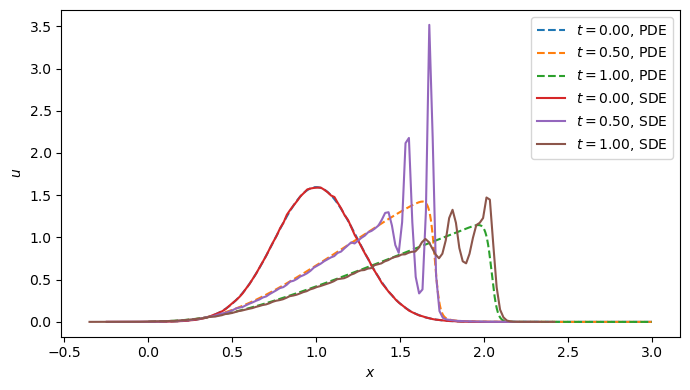

In [267]:
# Common parameters
nu = 0.01
Tmax = 1.0


### PDE solution ###
nx = 3001  # number of spatial grid points
x, dx = np.linspace(0, 3, nx, retstep=True)
u0 = gaussian(x, 1, 0.25)
dt = 0.00001

# Check stability condition for this method
print(f'K*dt/dx**2 = {nu*dt/dx**2:.3f}')
print(f'CFL = {np.amax(u0)*dt/dx:.3f}')

u, times = burgers(u0, x, Tmax, dt, nu=nu)


fig = plt.figure(figsize=(7,4))
for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    plt.plot(x, u[it,:], '--', label=f'$t={it*dt:.2f}$, PDE')


### SDE solution ###
Np = 1000000
X0 = np.random.normal(loc=1, scale=0.25, size=Np)
dt = 0.002
bin_width = 0.02

X, times = burgers_SDE_histogram(X0, Tmax, dt, nu=nu, bin_width=bin_width)

bins = np.linspace(-2, 4, 300)
mids = bins[:-1] + (bins[1]-bins[0])/2


for t in [0, 0.5, 1]:
    it = np.argmin(np.abs(t - times))
    L = np.amax(X[it,:]) - np.amin(X[it,:])
    Nbins = int(L/bin_width) + 3
    bins = np.linspace(np.amin(X[it,:]) - 1.5*bin_width, np.amax(X[it,:]) + 1.5*bin_width, Nbins)
    mids = bins[:-1] + (bins[1]-bins[0])/2
    h, _ = np.histogram(X[it,:], bins=bins, density=True)
    plt.plot(mids, h, label=f'$t={it*dt:.2f}$, SDE')




plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.tight_layout()